In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

from datetime import datetime, timedelta
from scipy.io import wavfile

from goodvibes.utils.data import read_signature_information, read_target_run_log, read_gps_log, read_emplacement_information

%matplotlib inline

# Training Data Organization
The training data is located in the data directory of this repository and has the following structure:
- **signature_information.csv**: The file that contains every signature's metadata as well as the wav file that is associated with each row. Should be loaded as a Pandas Dataframe. 
- **target-run-logs.csv**: Contains all the information about every vehicle that was run in the experiments along with the target GPS log csv that is associated with each run. Some GPS files will span multiple runs, likely because the experiments took the same GPS model for vehicle to vehicle.
- **signatures directory**: Contains all the wav and xml files.
- **postion directory**: Contains all the GPS logs.

Now let's read in each of these files.

In [2]:
sig_info = read_signature_information('../data/signature_information.csv')
run_info = read_target_run_log('../data/target-run-log.csv')

In [3]:
# Columns in signature information
list(sig_info.columns)

['location',
 'node-id',
 'date',
 'time',
 'sampling_rate',
 'mode',
 'sequence-number',
 'producer',
 'data-file',
 'up-time-seconds',
 'hw-config',
 'sw-mode',
 'status',
 'sensor-time-seconds',
 'sensor-time',
 'sample-rate-nominal',
 'sample-rate-actual',
 'lat',
 'lon',
 'alt-above-geoid-meters',
 'geoidal-separation-meters',
 'gps-fix-time-seconds',
 'gps-fix-time',
 'num-satellites',
 'datetime']

In [4]:
print(sig_info.head())

  location  node-id       date                time  sampling_rate      mode  \
0     bprf      131 2023-04-12 1900-01-01 17:25:00           1605   seismic   
1     bprf      131 2023-04-12 1900-01-01 17:25:00           9865  acoustic   
2     bprf      131 2023-04-10 1900-01-01 18:25:00           1605   seismic   
3     bprf      131 2023-04-10 1900-01-01 18:30:00           9867  acoustic   
4     bprf      131 2023-04-10 1900-01-01 18:25:00           9865  acoustic   

   sequence-number                                           producer  \
0               53  Sensor version 80 UPDATE 2, compiled at Mar  1...   
1               53  Sensor version 80 UPDATE 2, compiled at Mar  1...   
2               55  Sensor version 80 UPDATE 2, compiled at Mar  1...   
3               56  Sensor version 80 UPDATE 2, compiled at Mar  1...   
4               55  Sensor version 80 UPDATE 2, compiled at Mar  1...   

                                       data-file  up-time-seconds  ...  \
0  Node131-C

In [5]:
# Columns in target run information
list(run_info.columns)

['location',
 'date',
 'run',
 'make',
 'model',
 'year',
 'type',
 'target-name',
 'target-id',
 'speed-kph',
 'speed-throttle',
 'direction',
 'start-time-utc',
 'mads-cpa-utc',
 'stop-time-utc',
 'gps-log-file',
 'comments',
 'nsin-release',
 'east-start-turnaround-lat',
 'east-start-turnaround-lon',
 'west-start-turnaround-lat',
 'west-start-turnaround-lon',
 'north-start-turnaround-lat',
 'north-start-turnaround-lon',
 'south-start-turnaround-lat',
 'south-start-turnaround-lon',
 'stop-datetime']

In [6]:
print(run_info.head())

  location       date  run       make    model    year type  \
0    eglin 2023-03-16    1     Toyota   Tacoma  2006.0  SR5   
1    eglin 2023-03-16    1  Chevrolet     S-10  1995.0  NaN   
2  cochise 2023-04-10    1     Toyota  4Runner     NaN  NaN   
3  cochise 2023-04-10    2     Toyota  4Runner     NaN  NaN   
4  cochise 2023-04-10    3     Toyota  4Runner     NaN  NaN   

              target-name target-id  speed-kph  ...             nsin-release  \
0  2006 Toyota Tacoma SR5        1A       25.0  ...  2 - Developers Data Set   
1     1995 Chevrolet S-10        1B       25.0  ...  2 - Developers Data Set   
2          Toyota 4Runner        3A       20.0  ...  2 - Developers Data Set   
3          Toyota 4Runner        3A       20.0  ...  2 - Developers Data Set   
4          Toyota 4Runner        3A       20.0  ...  2 - Developers Data Set   

  east-start-turnaround-lat east-start-turnaround-lon  \
0                       NaN                       NaN   
1                       Na

Lastly, we need to do a little bit of processing to but some of the columns in the right format.

In [11]:
sig_info['datetime'] = pd.to_datetime(sig_info['date'] + ' ' + sig_info['time'], format='%Y-%m-%d %H:%M:%S')
sig_info['date'] = pd.to_datetime(sig_info['date'], format='%Y-%m-%d')
sig_info['time'] = pd.to_datetime(sig_info['time'], format='%H:%M:%S')
sig_info['sensor-time'] = pd.to_datetime(sig_info['sensor-time'])
sig_info['gps-fix-time'] = pd.to_datetime(sig_info['gps-fix-time'])
run_info['start-datetime'] = pd.to_datetime(run_info['date'] + ' ' + run_info['start-time-utc'], format='mixed', yearfirst=True)
run_info['stop-datetime'] = pd.to_datetime(run_info['date'] + ' ' + run_info['stop-time-utc'], format='mixed', yearfirst=True)
run_info['date'] = pd.to_datetime(run_info['date'])
run_info['start-time-utc'] = pd.to_datetime(run_info['start-time-utc'], format='mixed').apply(lambda value: value.time()) 
run_info['stop-time-utc'] = pd.to_datetime(run_info['stop-time-utc'], format='mixed').apply(lambda value: value.time()) 

# Example Acoustic Analysis
Now that we have loaded the metadata from both the signature files and target runs, we can begin with a sample acoustic analysis to explore what types of signatures can be deduced from a vehicle presence or not. 

Let's begin by processing the entire Eglin audio stream from a single sensor, i.e., sensor 80. 

In [8]:
# Focus on sensor 80 and sort on datetime
eglin_signatures_80 = sig_info[(sig_info['location'] == 'eglin') & (sig_info['mode'] == 'acoustic') & (sig_info['node-id'] == 80)].sort_values('datetime')

In [9]:
# Now let's collect and read in all these signatures into a single audio file
SIGNATURES_ROOT = '../data/signatures/'
rate = None
audio_data = []
for i, row in eglin_signatures_80.iterrows():
    wav = os.path.join(SIGNATURES_ROOT, row['data-file'])
    _rate, _data = wavfile.read(wav)
    if not rate:
        rate = _rate
    if rate != _rate:
        print('Warning: Rates not equal')
    audio_data.append(_data)
audio_data = np.concatenate(audio_data)

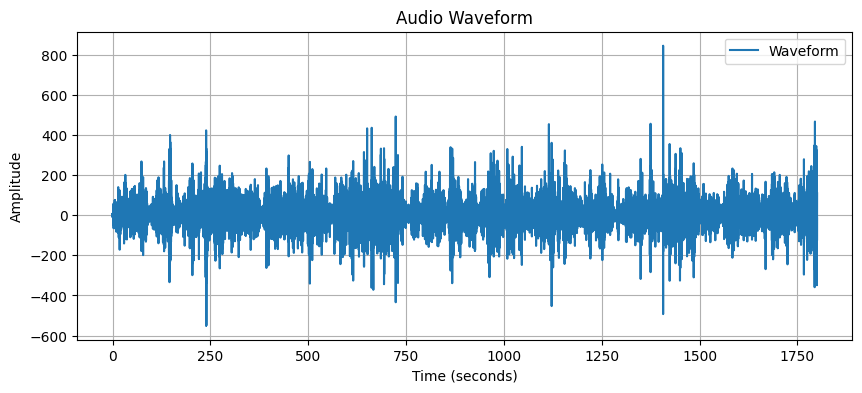

In [10]:
# Create a time axis in seconds
time = np.linspace(0, len(audio_data) / rate, num=len(audio_data))

# Plotting the audio data
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, label='Waveform')
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Now, let's map in the locations where the vehicles are driving, i.e., start and end times of the runs. 

/home/chase/src/research/projects/goodvibes/goodvibes-venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


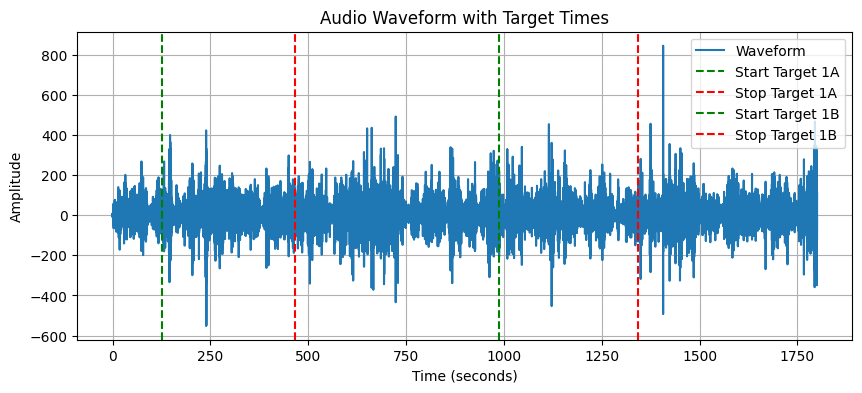

In [11]:
# Get the audio start time for reference
audio_start_datetime = eglin_signatures_80['datetime'].iloc[0]

# Eglin Targets
targets = run_info[run_info['location'] == 'eglin']['target-id'].unique()
start_points = []
stop_points = []
for target in targets:
    start_datetime = run_info[(run_info['location'] == 'eglin') & (run_info['target-id'] == target)]['start-datetime'].iloc[0] - audio_start_datetime
    stop_datetime = run_info[(run_info['location'] == 'eglin') & (run_info['target-id'] == target)]['stop-datetime'].iloc[0] - audio_start_datetime

    # Convert to seconds since the start of the audio file
    start_seconds = start_datetime.total_seconds()
    stop_seconds = stop_datetime.total_seconds()

    # Append to lists
    start_points.append(start_seconds)
    stop_points.append(stop_seconds)

plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, label='Waveform')
plt.title('Audio Waveform with Target Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Plotting start and stop points
for start, stop, target in zip(start_points, stop_points, targets):
    plt.axvline(x=start, color='green', linestyle='--', label=f'Start Target {target}')
    plt.axvline(x=stop, color='red', linestyle='--', label=f'Stop Target {target}')

plt.legend()
plt.grid(True)
plt.show()

## Frequency spectrum of targets
Now let's look at the FFT of each target during it's run frequency and compare that with the frequency sprectrum of no run time to see if there is anything of interest. 

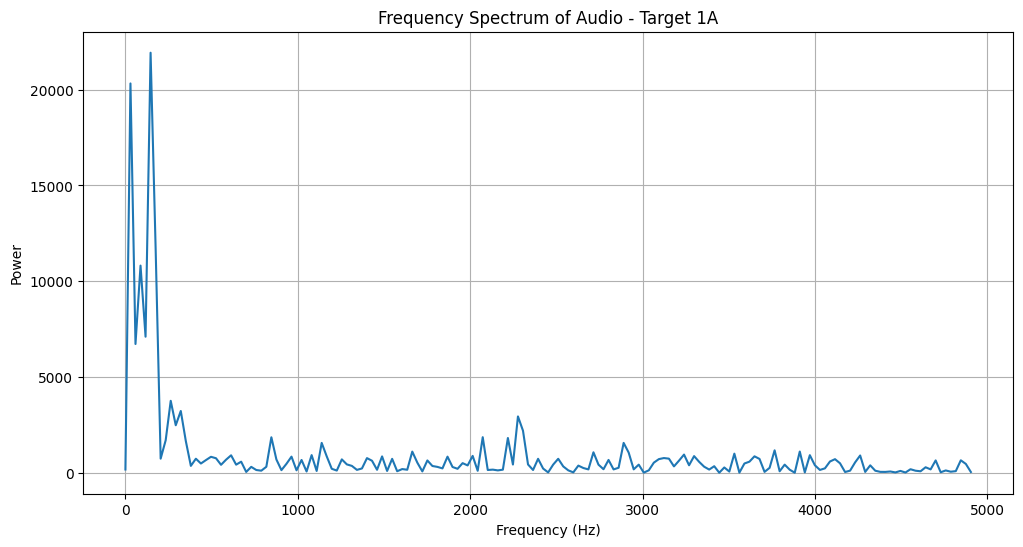

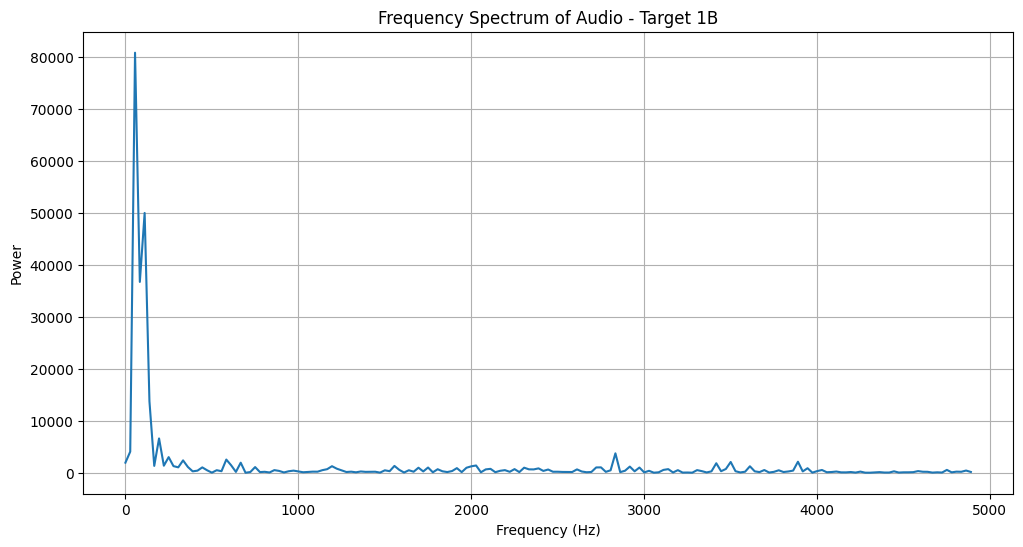

In [12]:
for start, stop, target in zip(start_points, stop_points, targets):
    fft_data = np.fft.fft(audio_data[int(start):int(stop)])
    
    # Get the power spectrum
    power = np.abs(fft_data)**2
    
    # Generate frequency axis
    frequencies = np.fft.fftfreq(len(fft_data), 1 / rate)
    
    # Only plot the first half of the FFT, since it's symmetric
    half_range = len(frequencies) // 2
    
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:half_range], power[:half_range])
    plt.title(f'Frequency Spectrum of Audio - Target {target}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.show()

## Frequency spectrum of noise
Now let's look at the FFT of each period with no target running.

[0, 465.0, 1343.0]
[127.0, 988.0, -50]


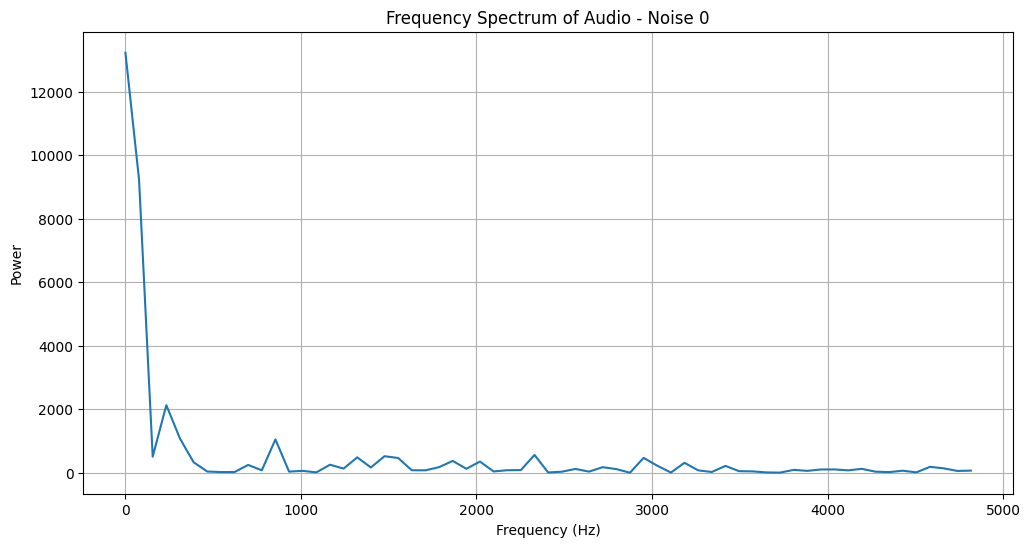

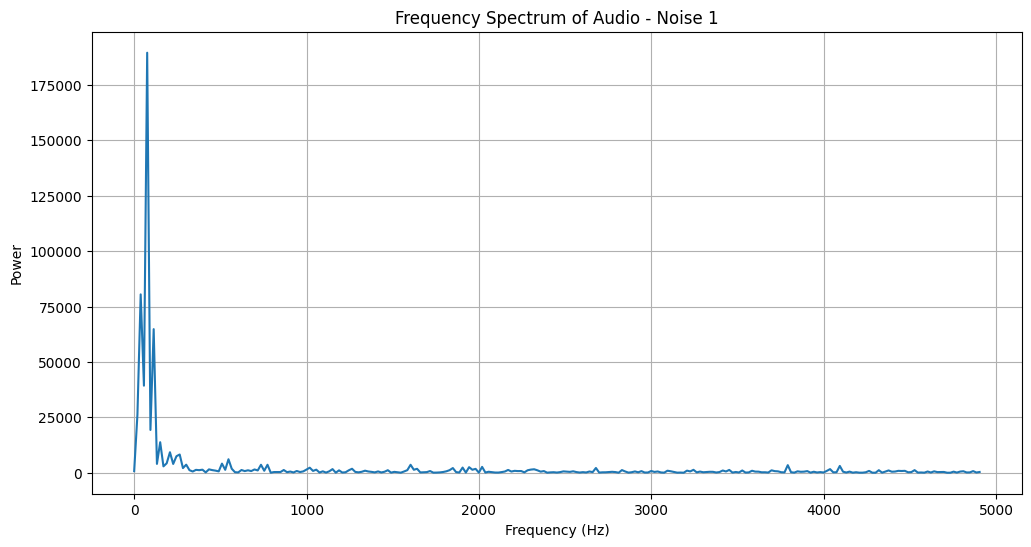

In [ ]:
noise_start_points = [0] + stop_points
noise_stop_points = start_points + [-50]
print(noise_start_points)
print(noise_stop_points)

for i, (start, stop) in enumerate(zip(noise_start_points, noise_stop_points)):
    fft_data = np.fft.fft(audio_data[int(start):int(stop)])
    
    # Get the power spectrum
    power = np.abs(fft_data)**2
    
    # Generate frequency axis
    frequencies = np.fft.fftfreq(len(fft_data), 1 / rate)
    
    # Only plot the first half of the FFT, since it's symmetric
    half_range = len(frequencies) // 2
    
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:half_range], power[:half_range])
    plt.title(f'Frequency Spectrum of Audio - Noise {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.show()

# GPS Logs
Now let's look at the GPS logs for the target trajectories in regard to all microphone locations.

In [3]:
# First load trajectory data and emplacement data
emplacement = read_emplacement_information('../data/emplacement_information.csv')

In [4]:
emplacement.head()

location  node-id       date        lat         lon      placement  \
0    eglin       80 2023-03-16  30.619685  -86.283243  3M, West Side   
1    eglin       81 2023-03-16  30.619688  -86.283241  3M, West Side   
2  cochise       81 2023-04-10  31.617125 -110.242556             1M   
3  cochise      121 2023-04-10  31.619073 -110.240333             1M   
4  cochise       81 2023-04-11  31.617077 -110.242583             1M   

  microphone-cover          nsin-release  
0              NaN  2-Developer Data Set  
1              NaN  2-Developer Data Set  
2              NaN  2-Developer Data Set  
3              NaN  2-Developer Data Set  
4              NaN  2-Developer Data Set

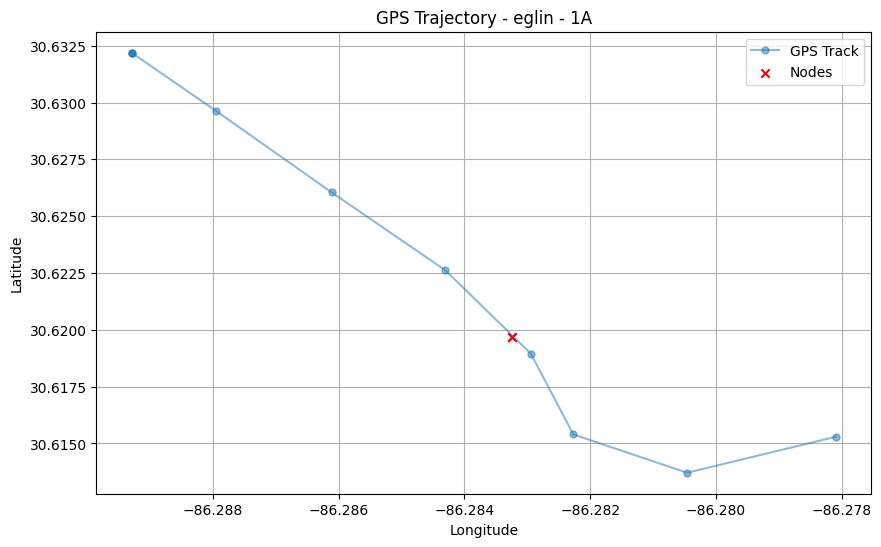

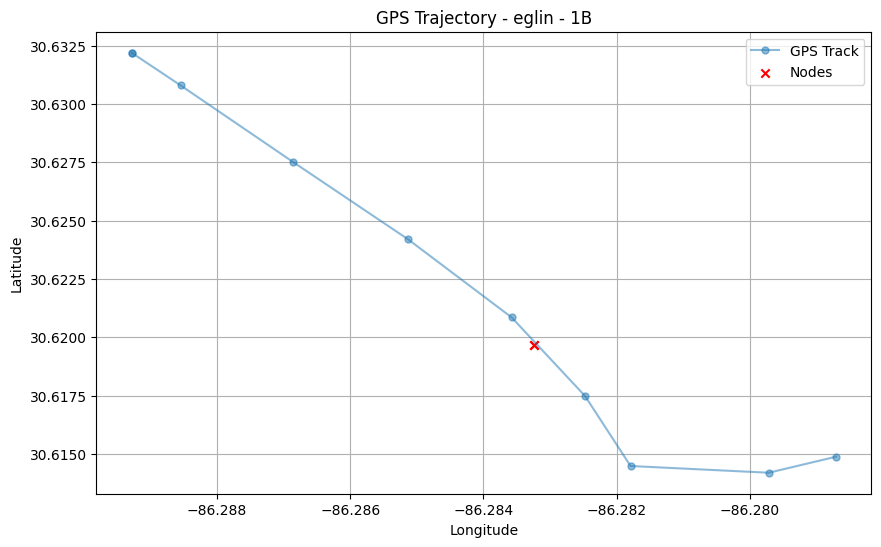

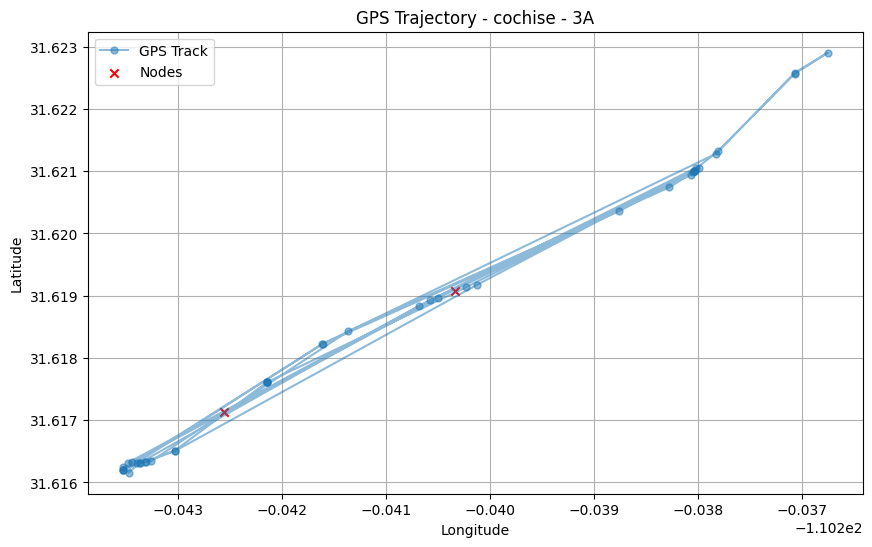

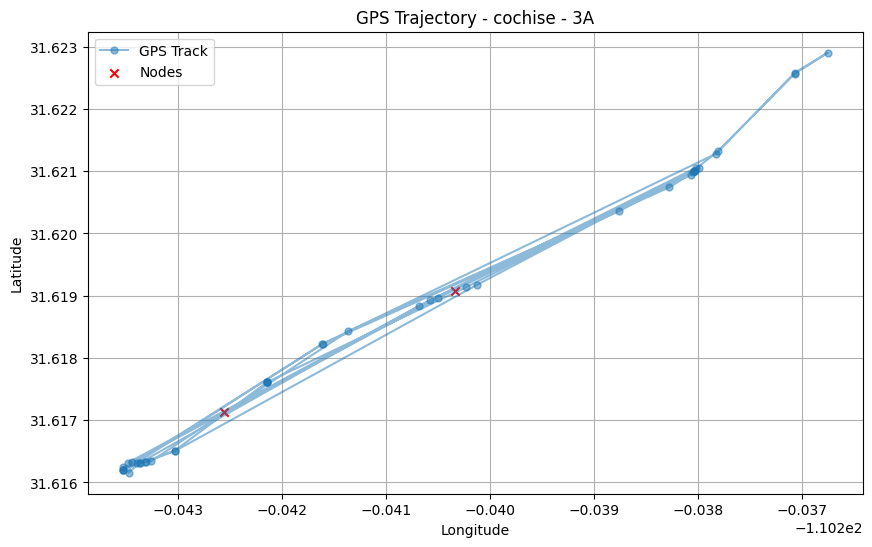

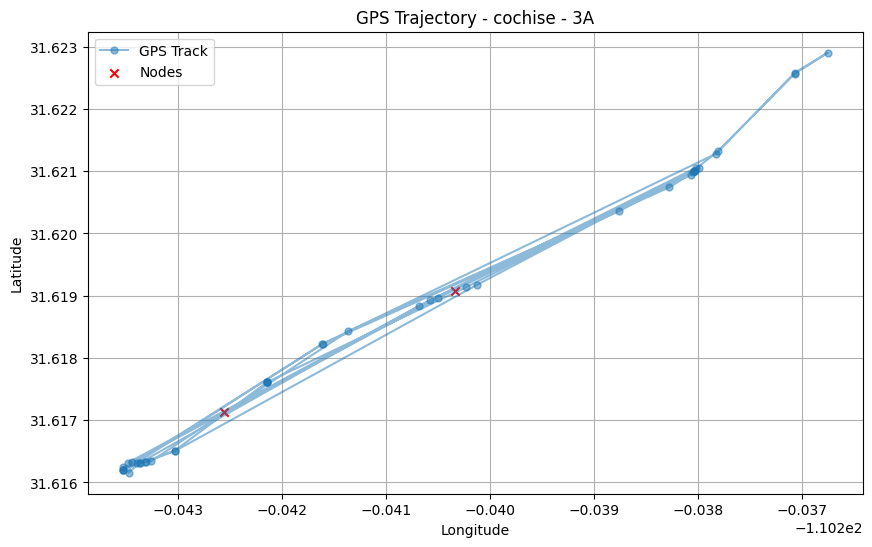

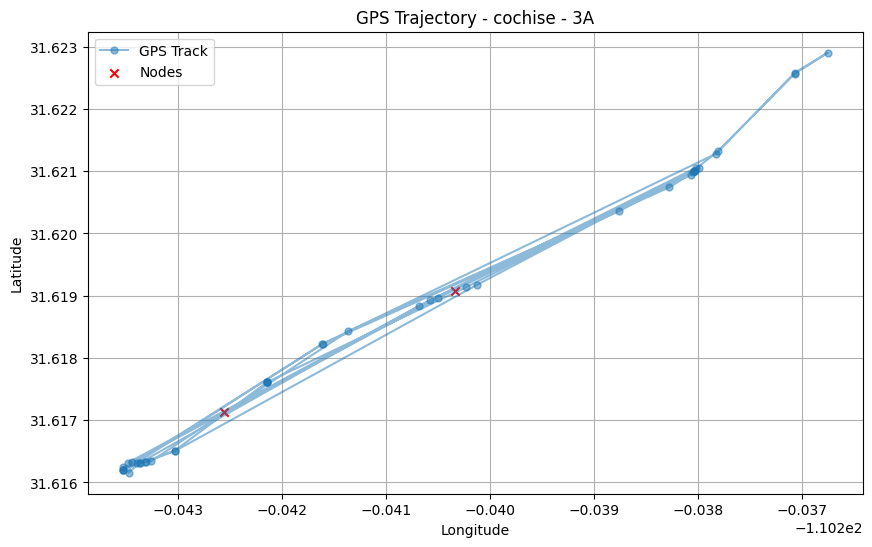

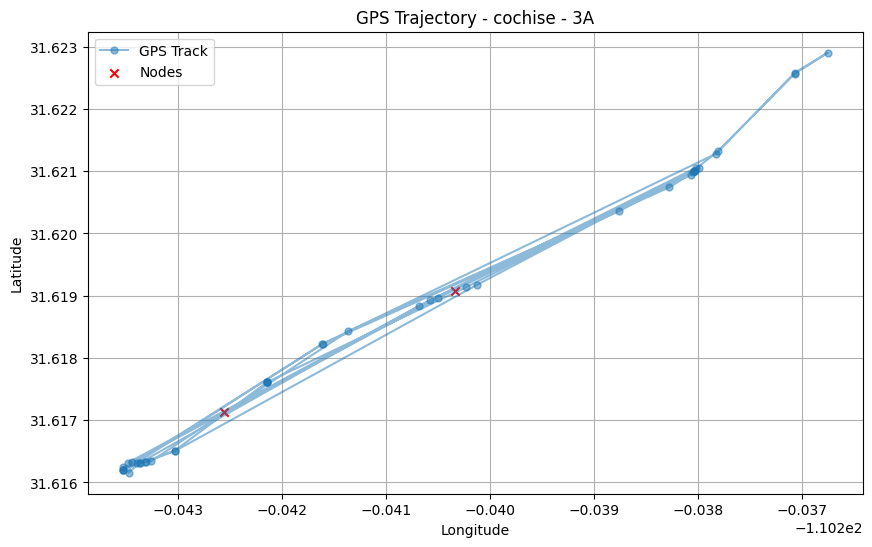

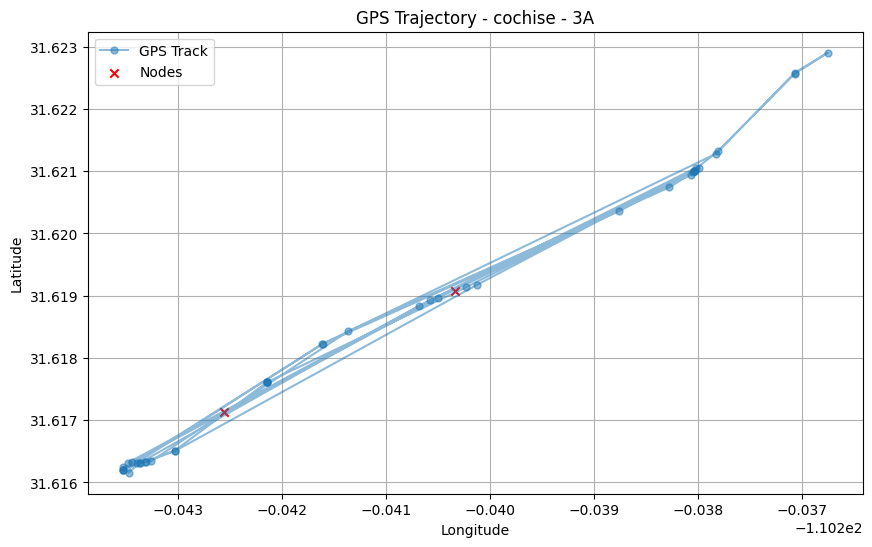

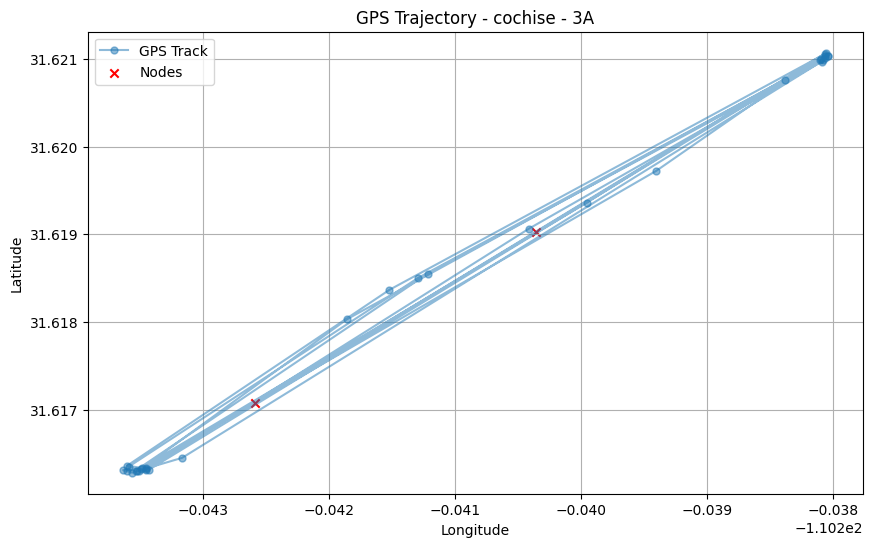

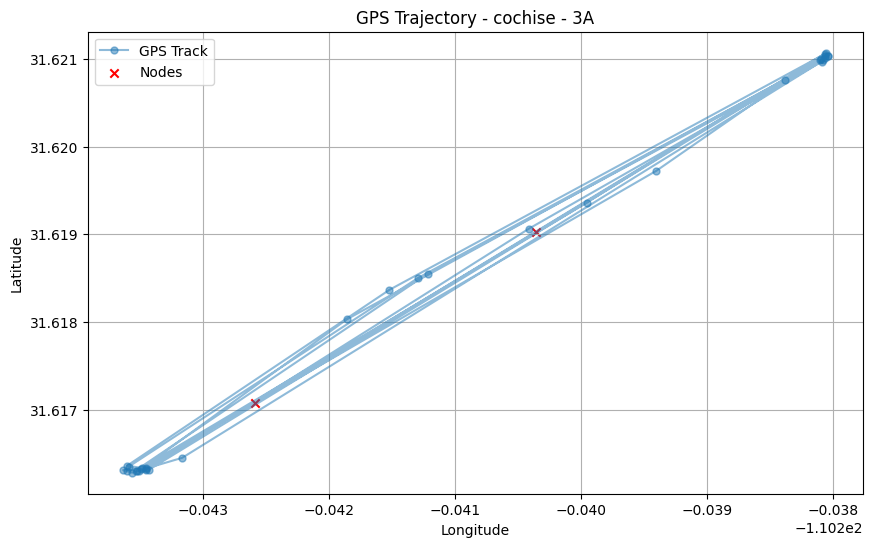

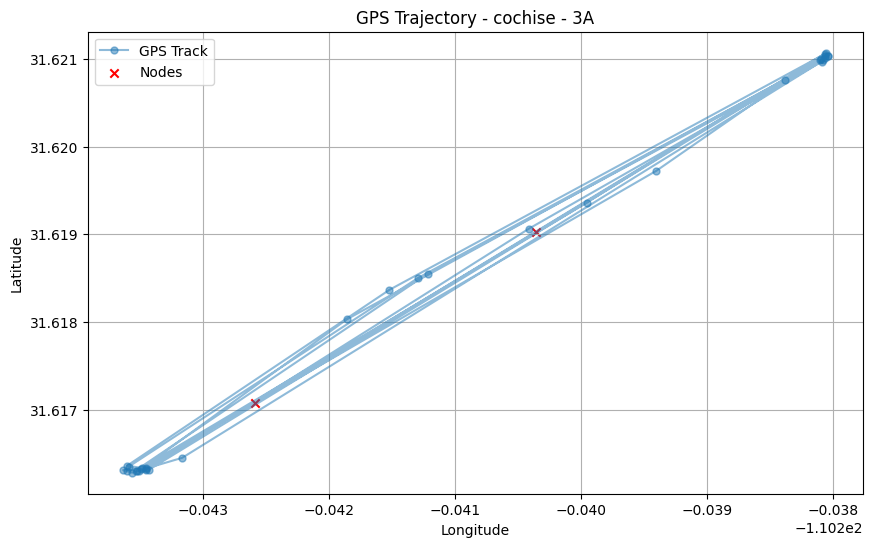

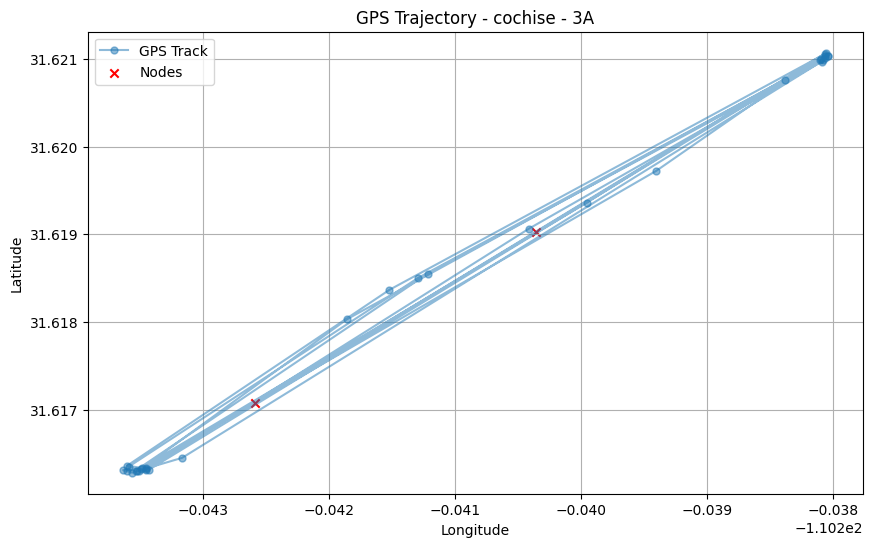

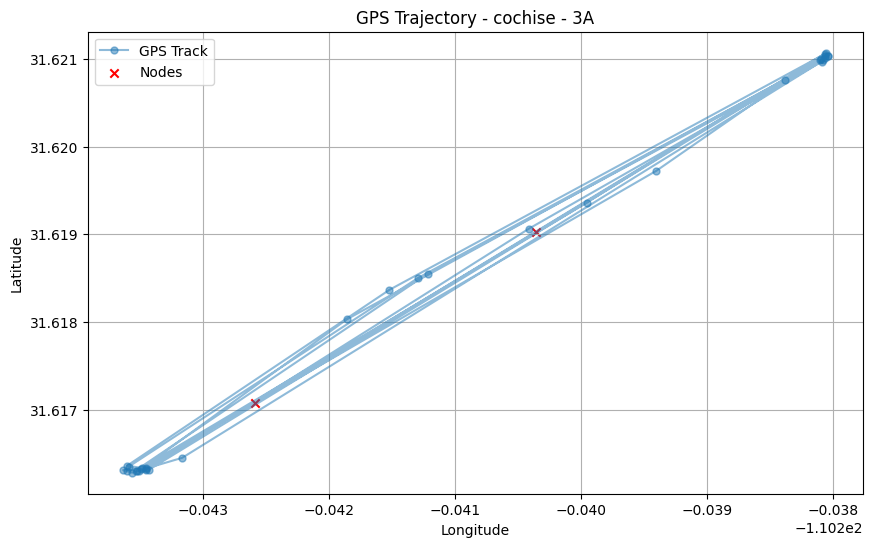

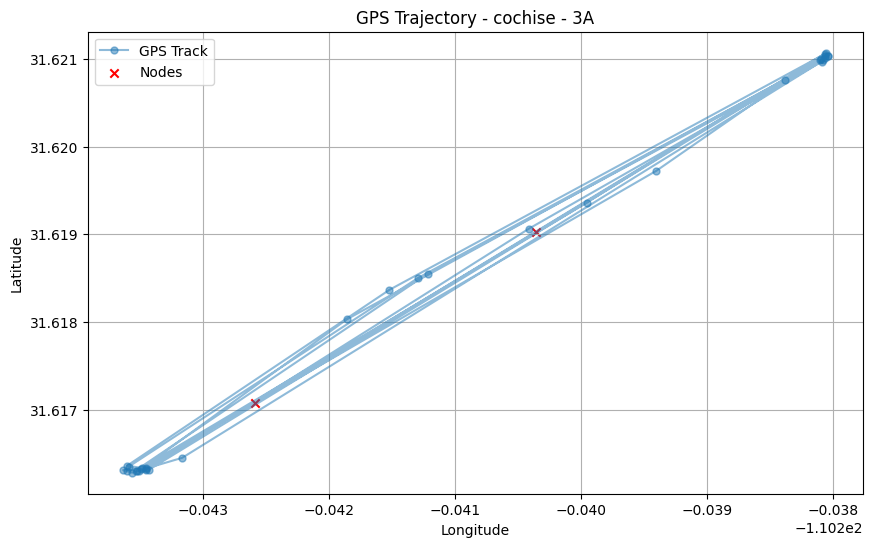

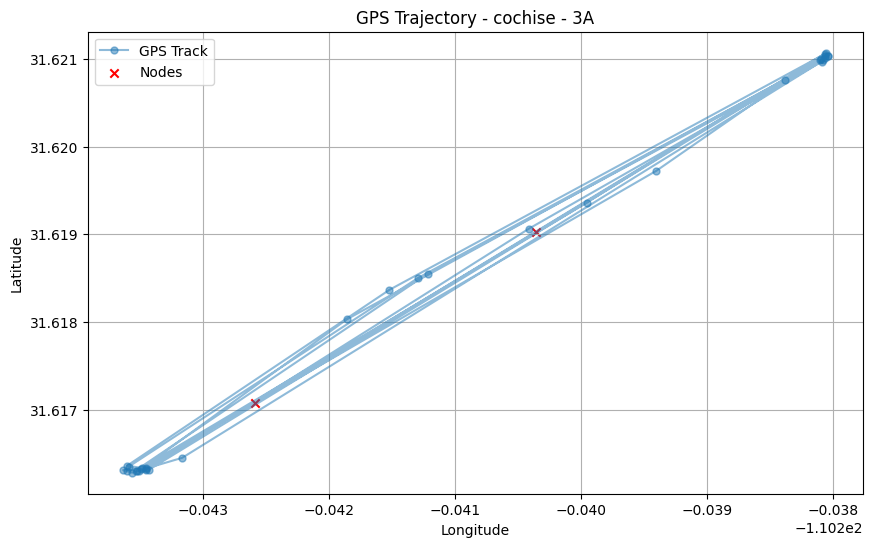

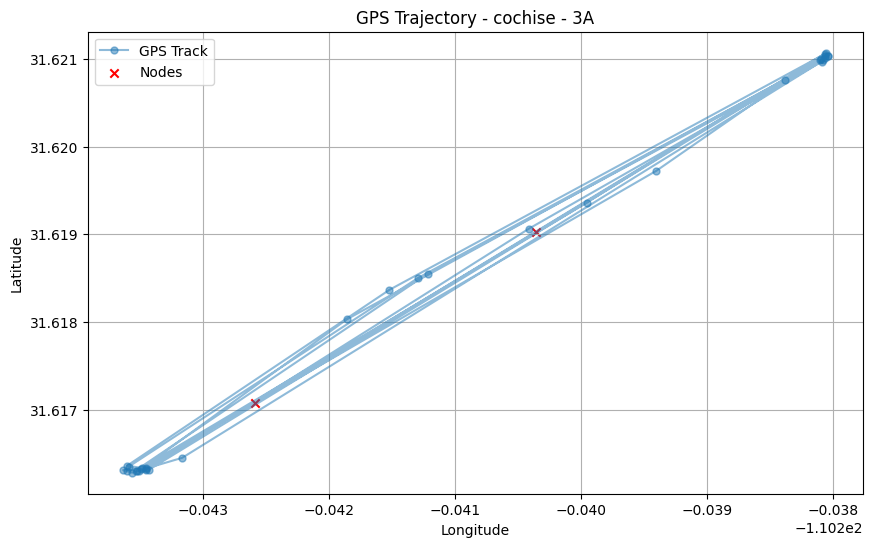

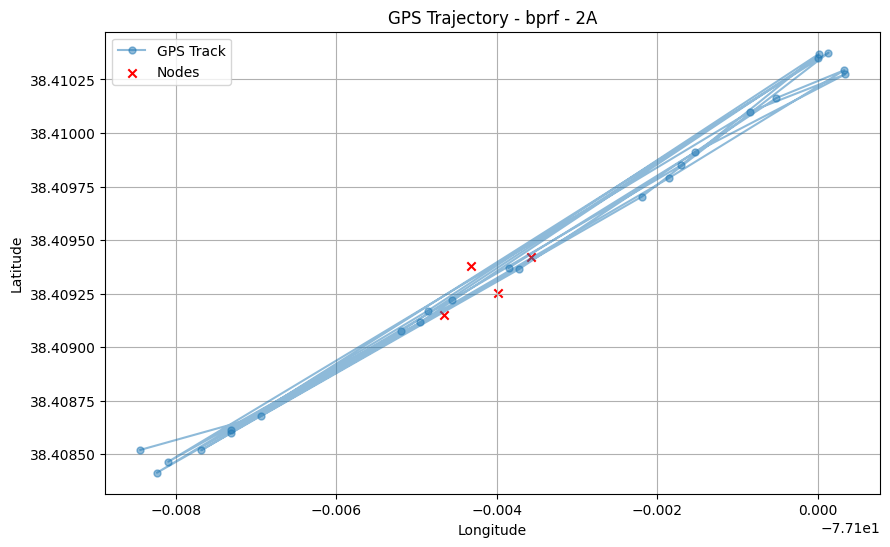

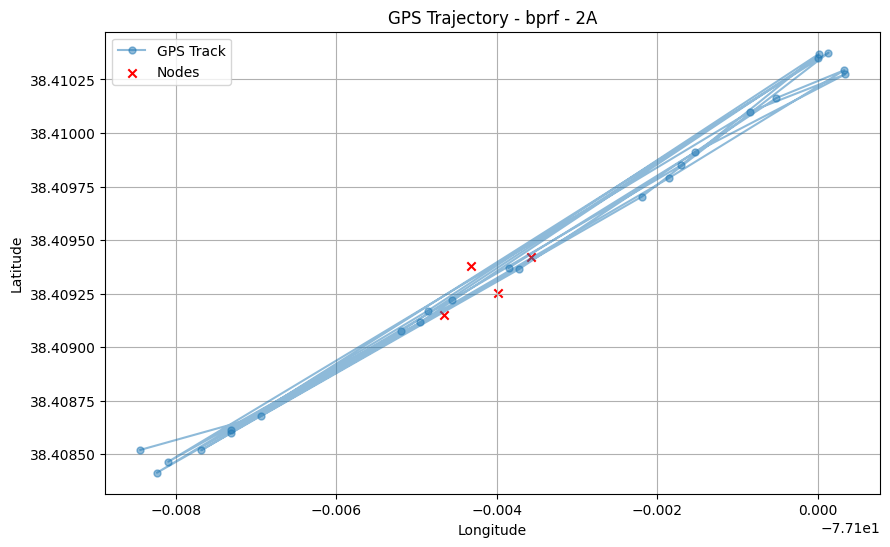

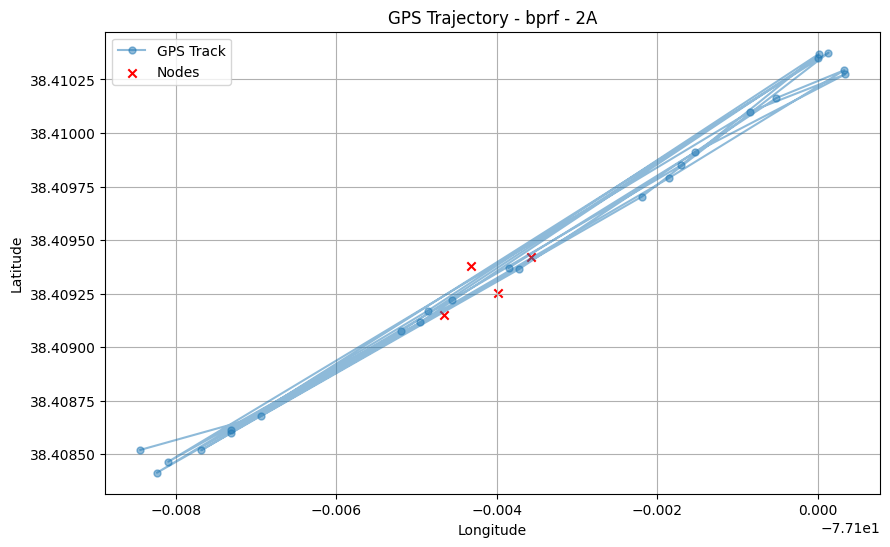

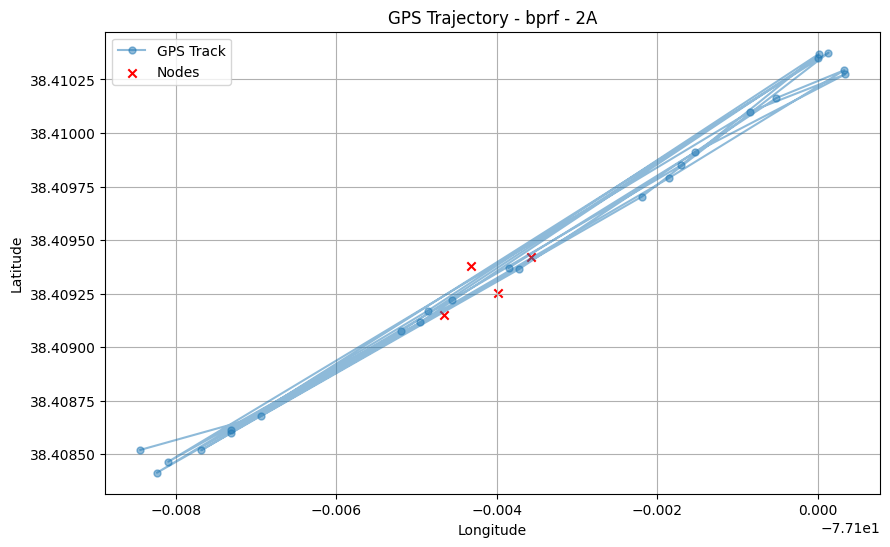

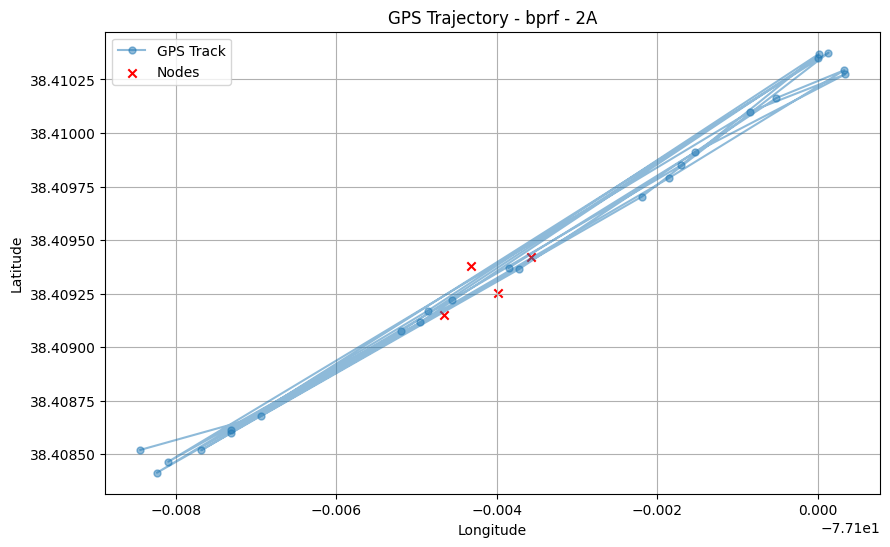

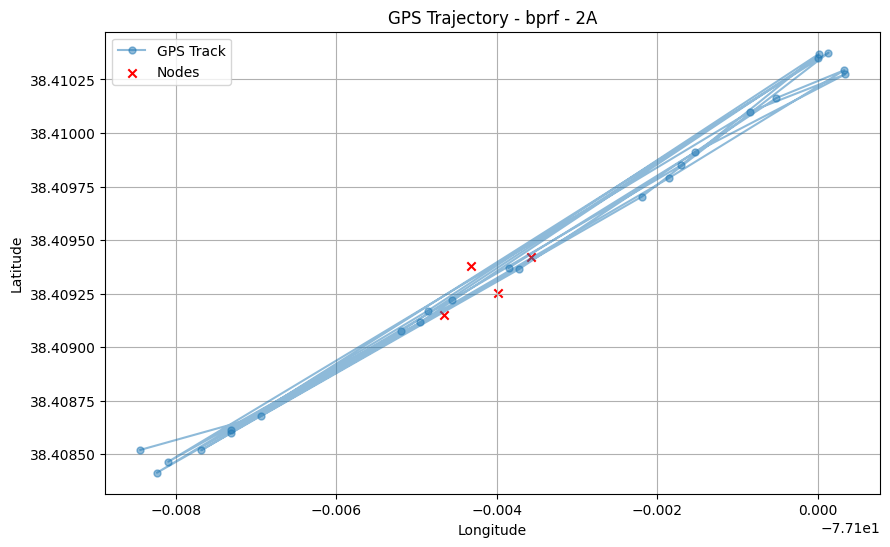

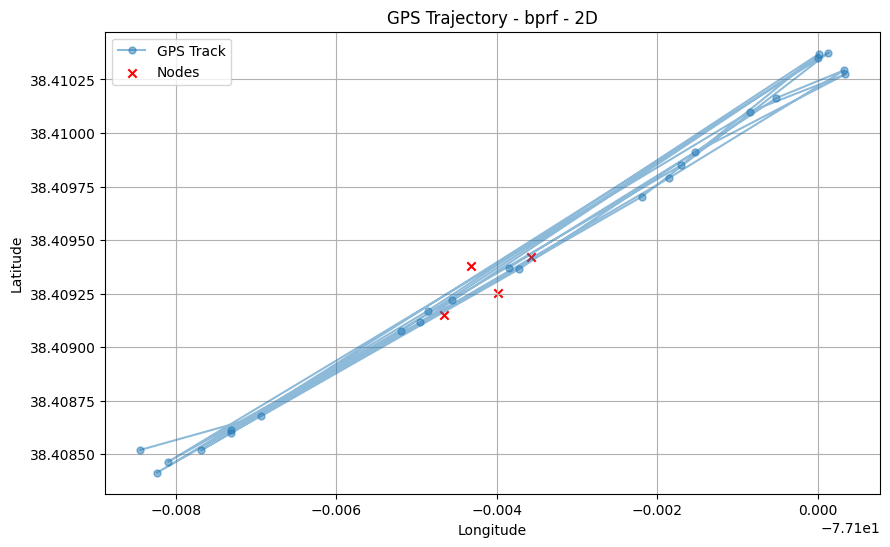

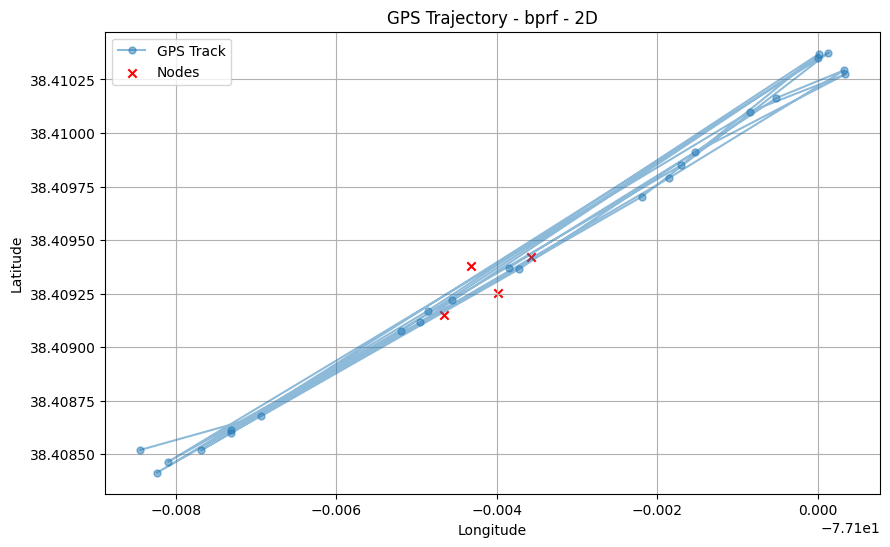

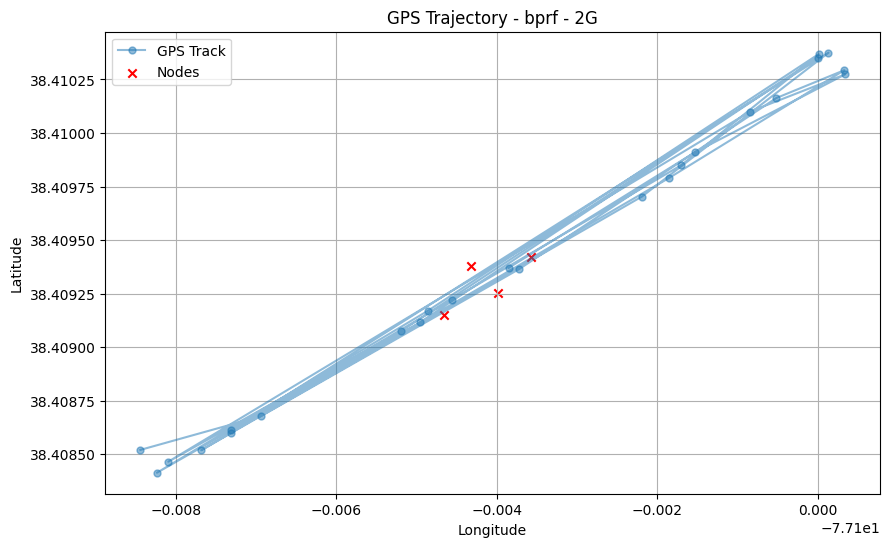

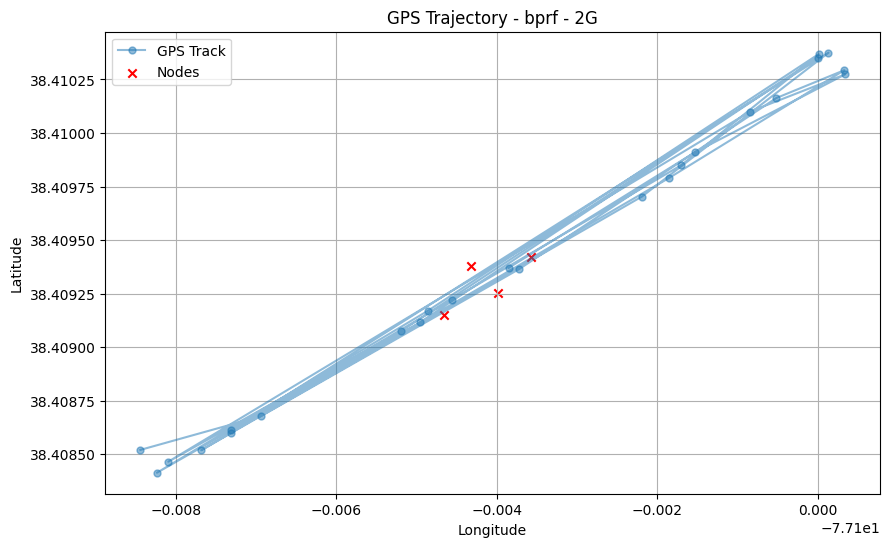

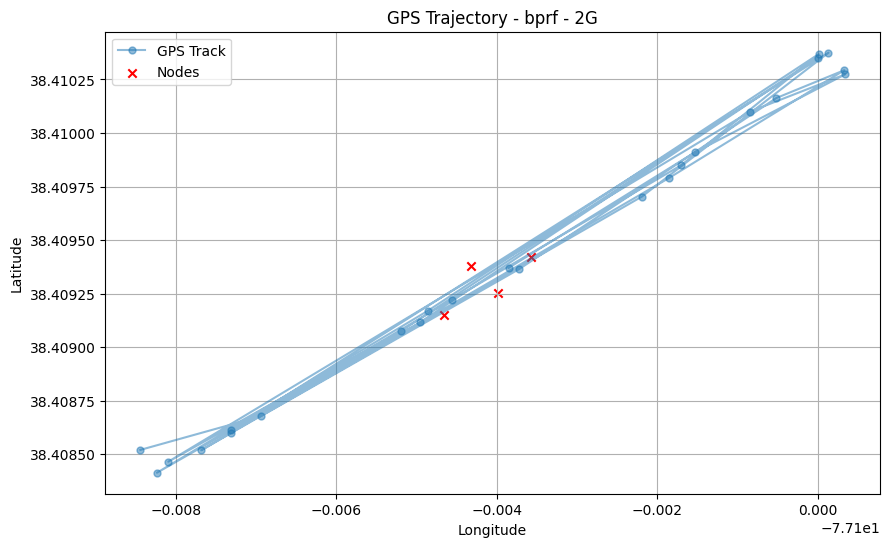

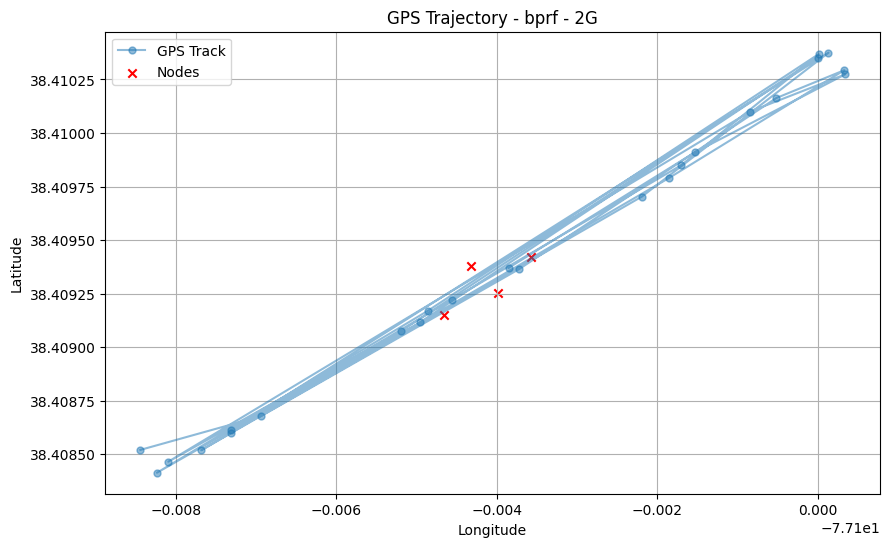

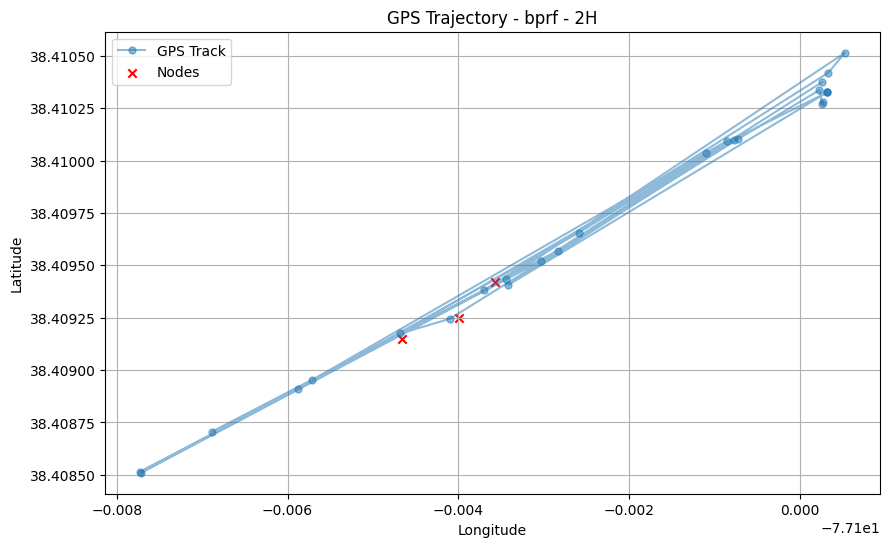

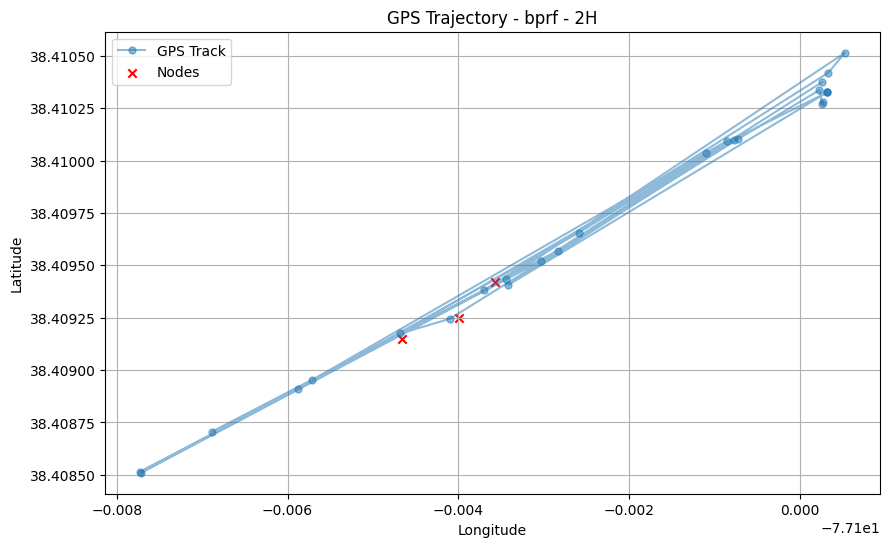

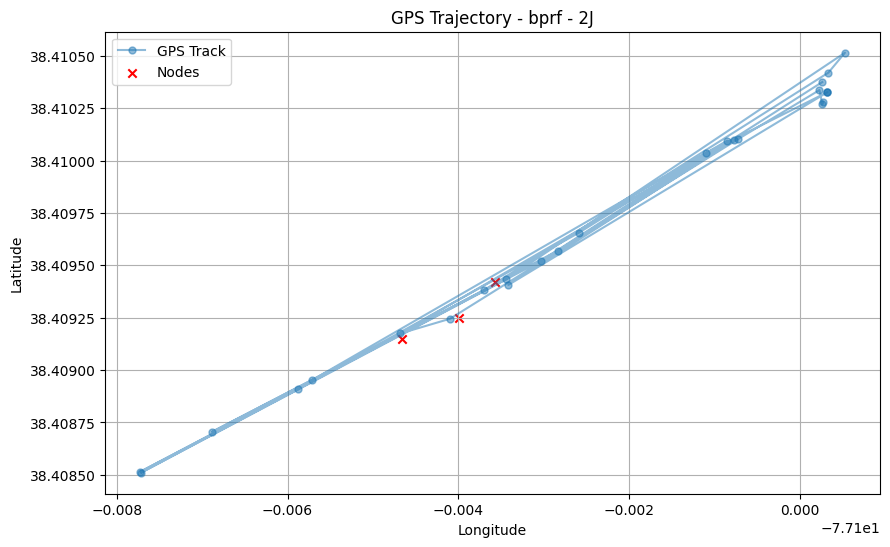

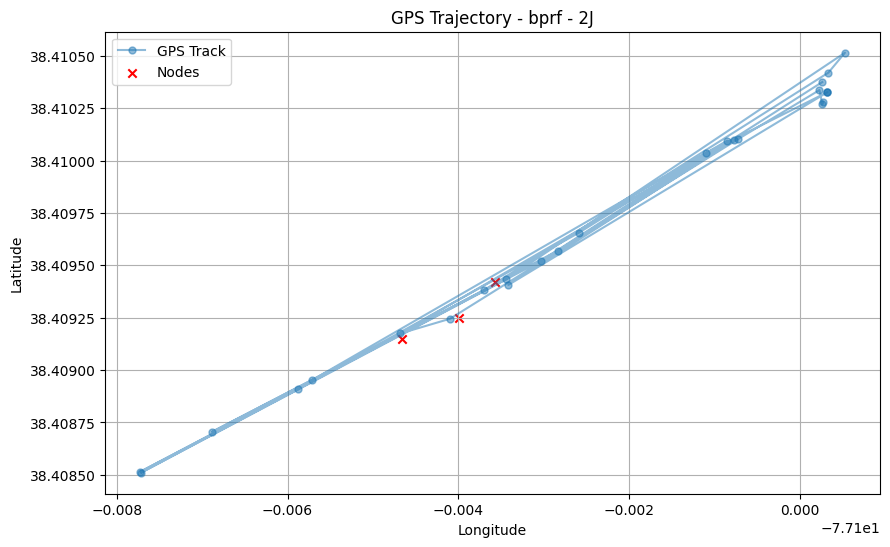

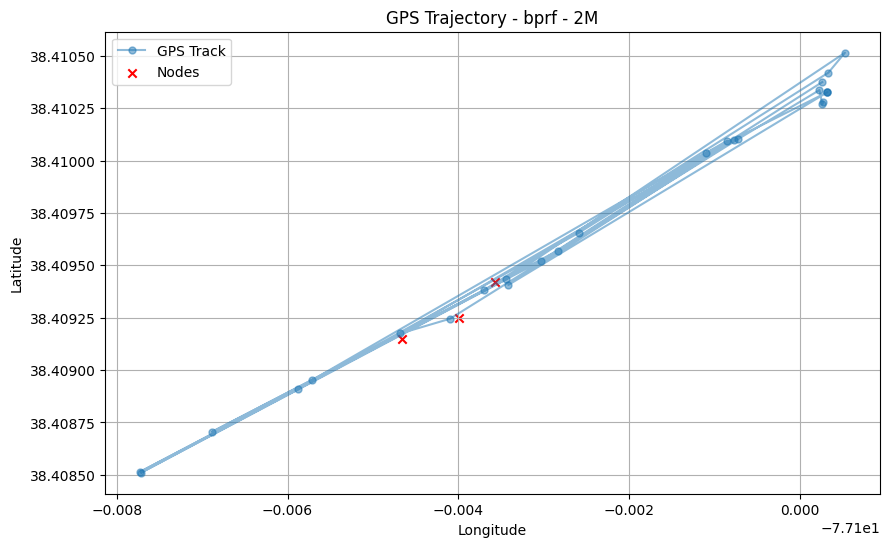

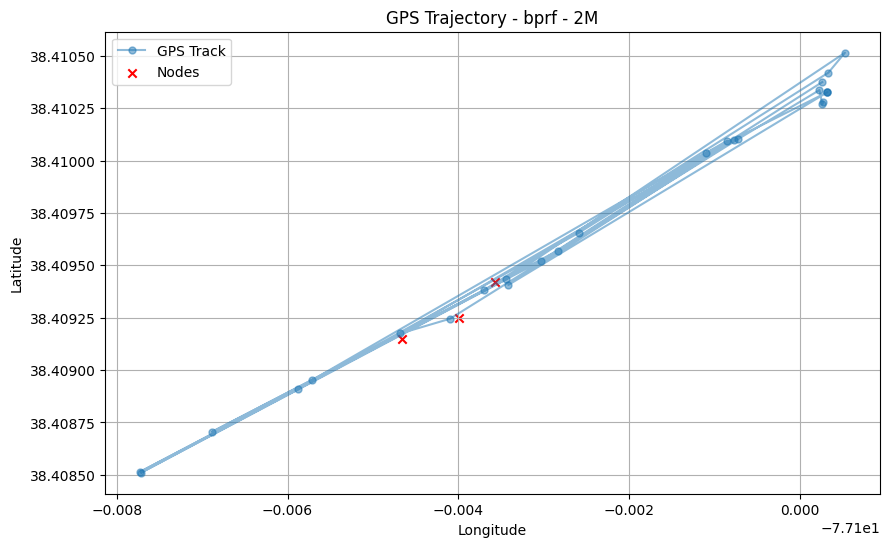

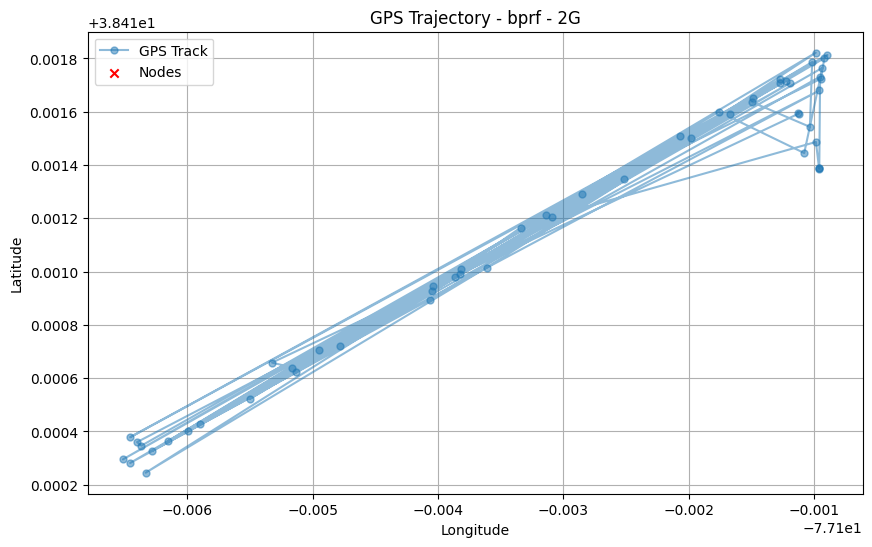

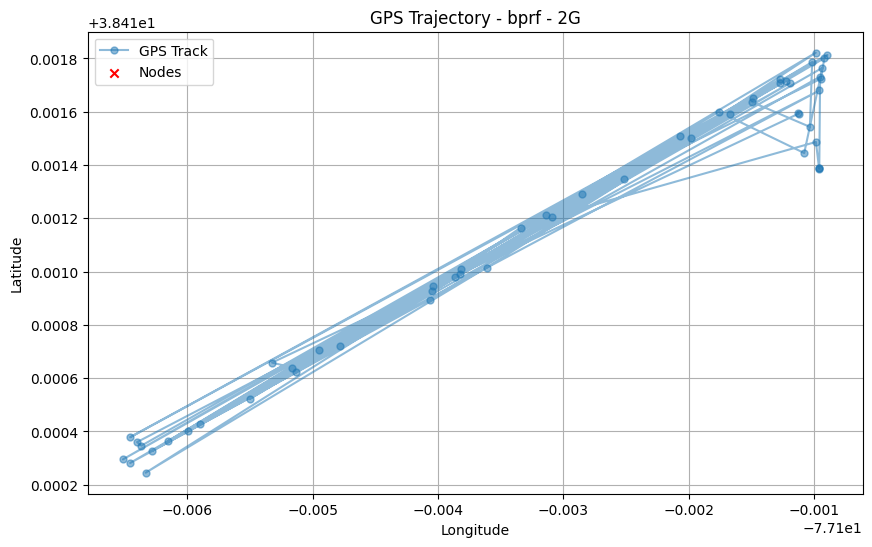

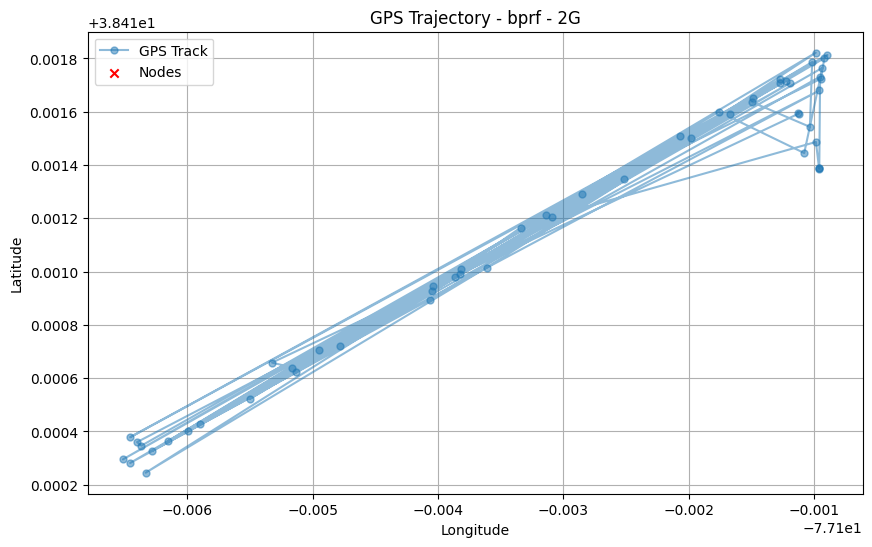

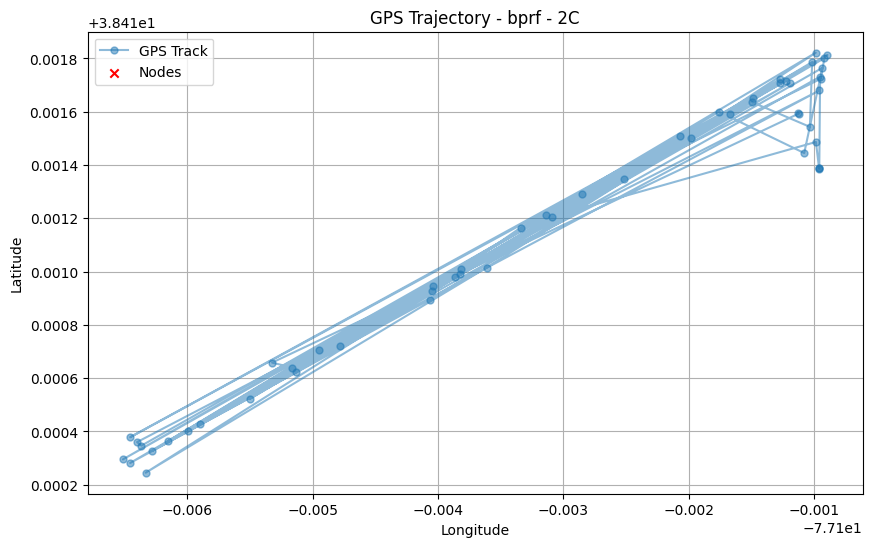

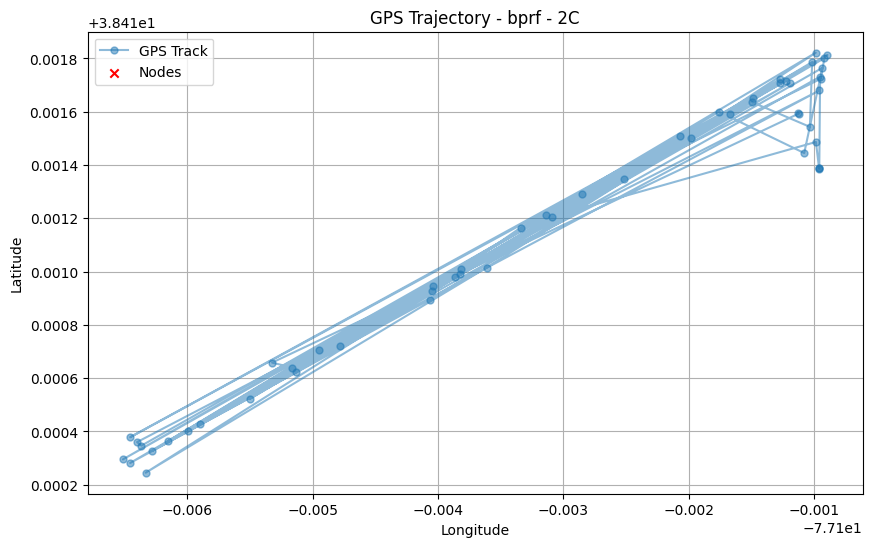

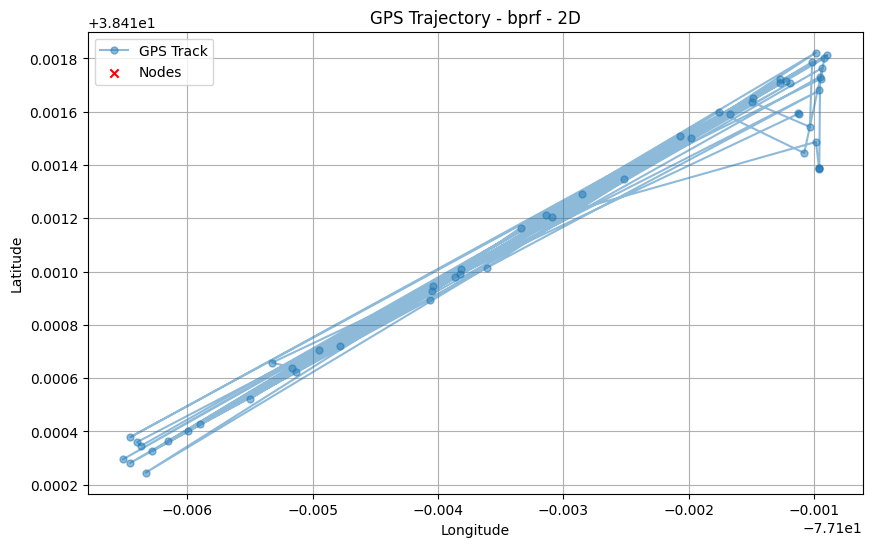

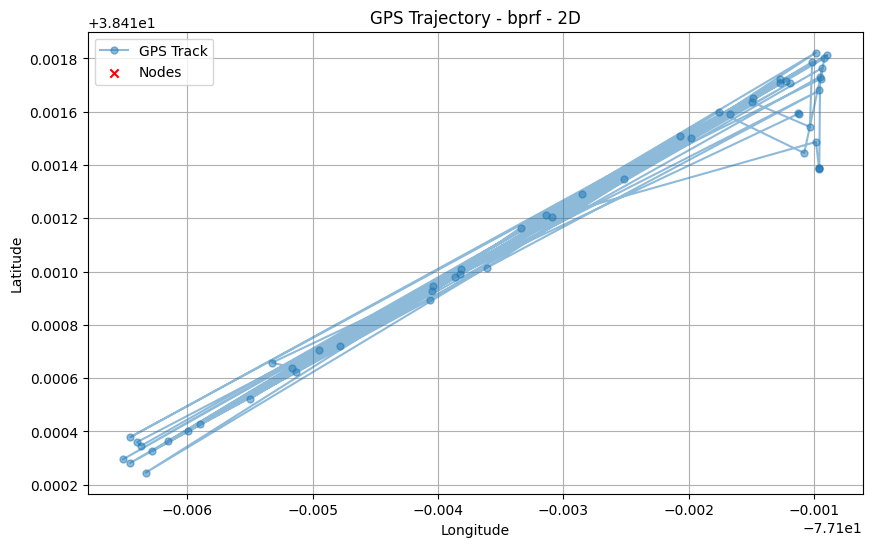

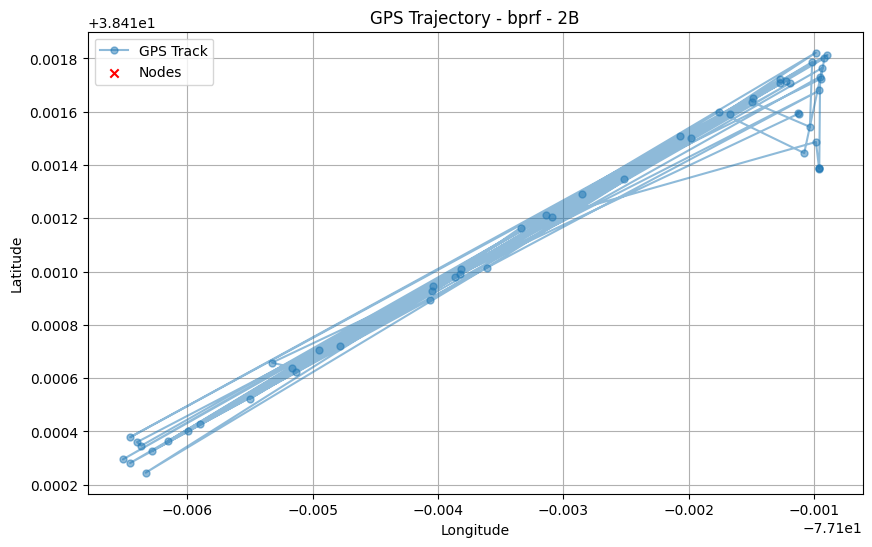

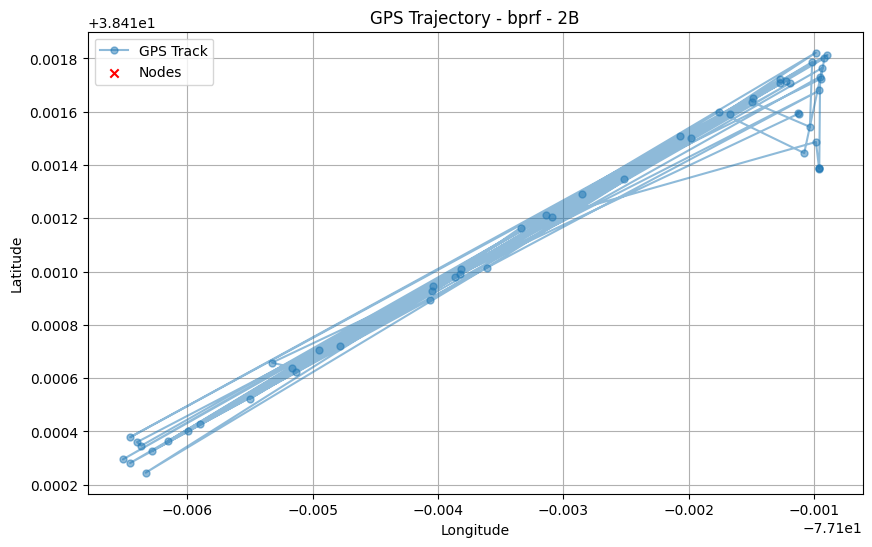

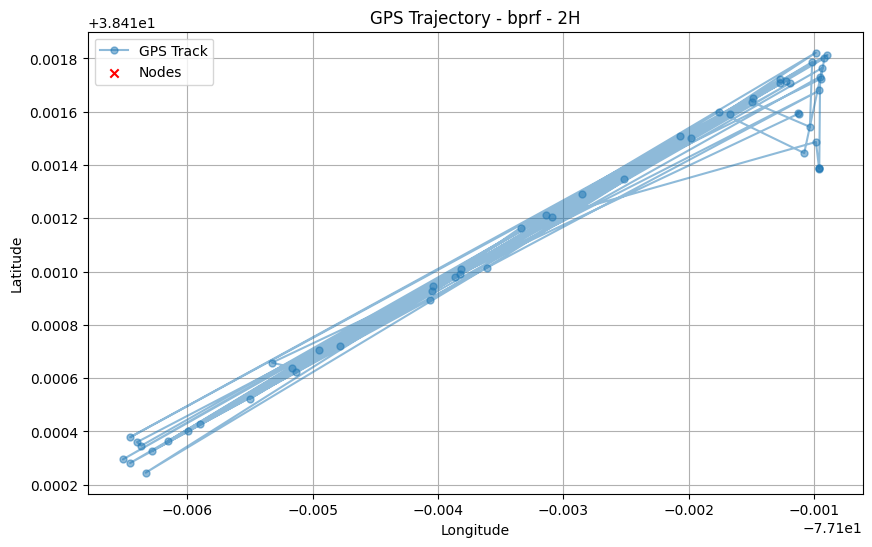

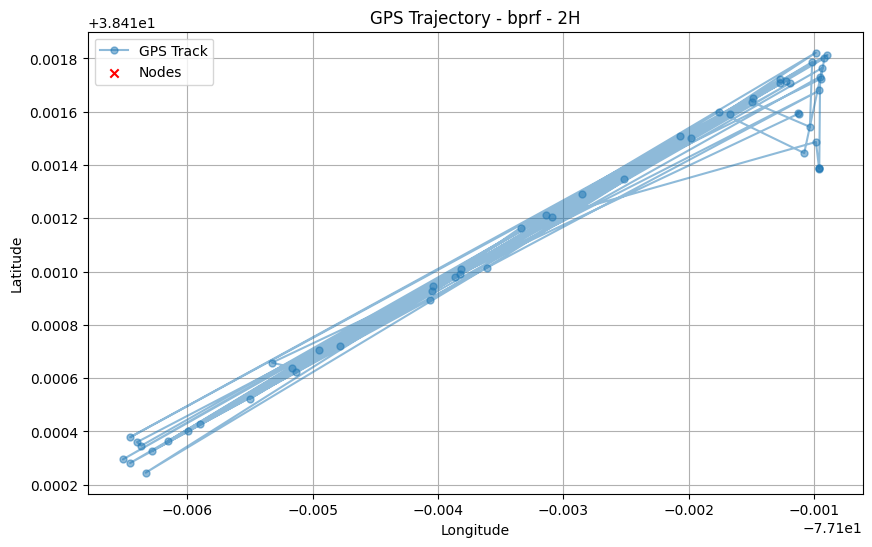

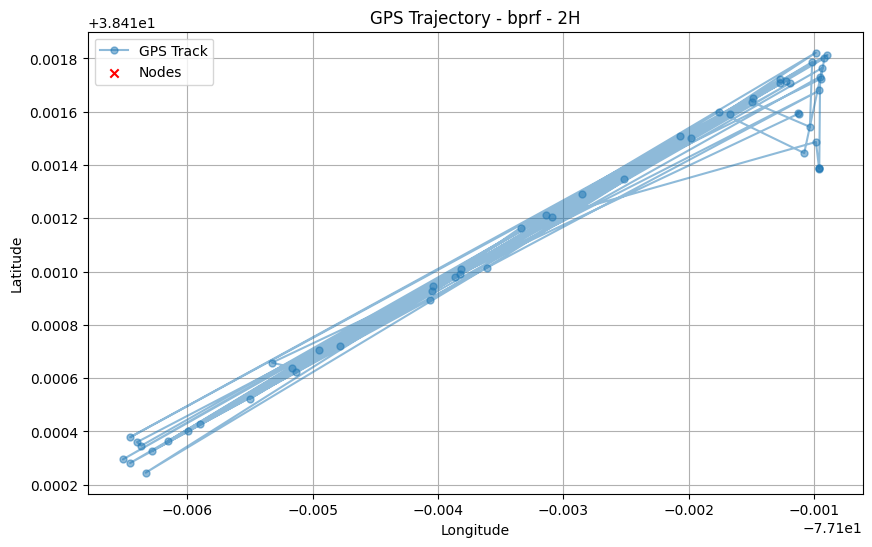

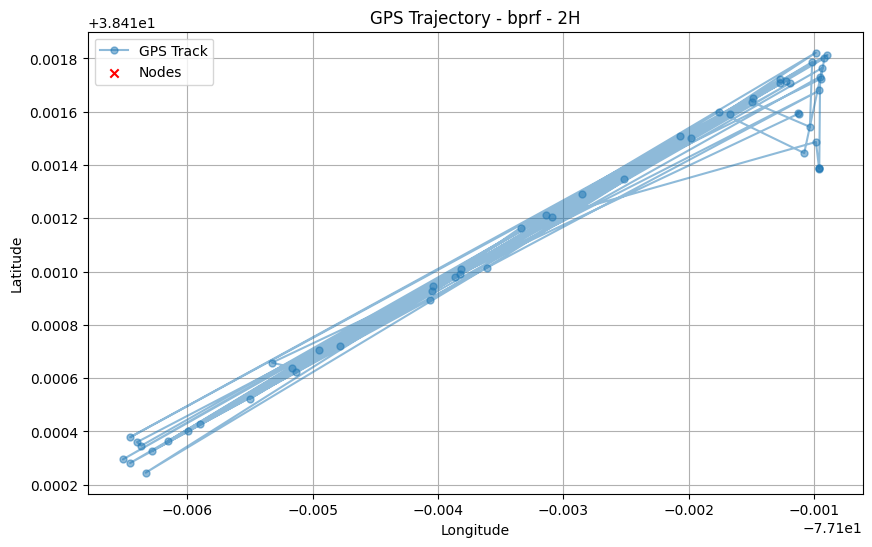

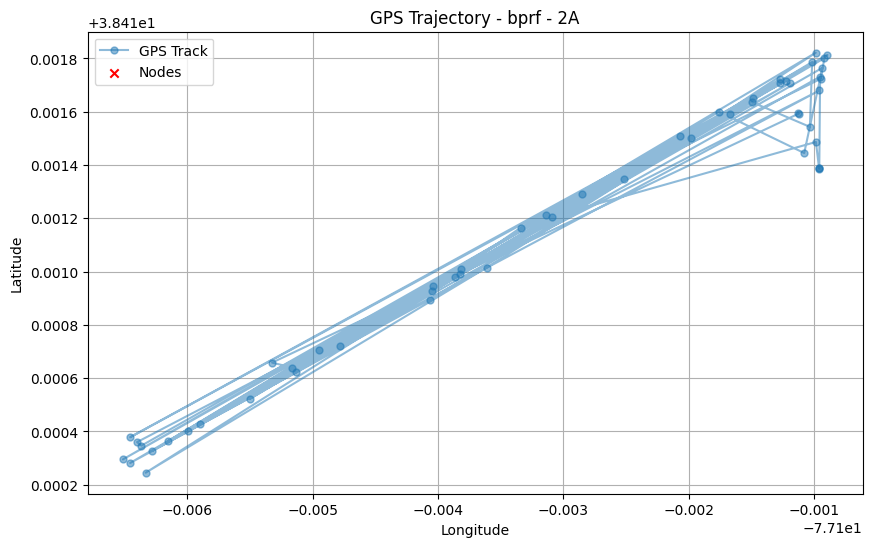

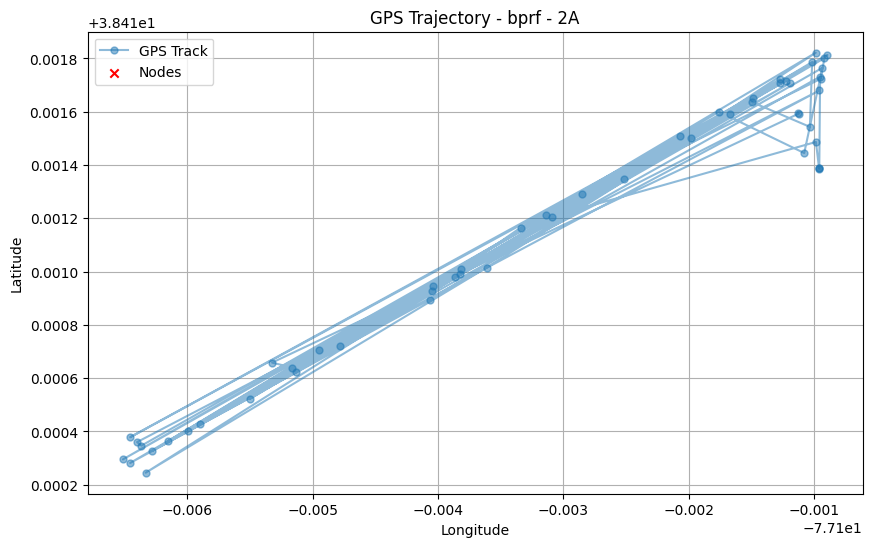

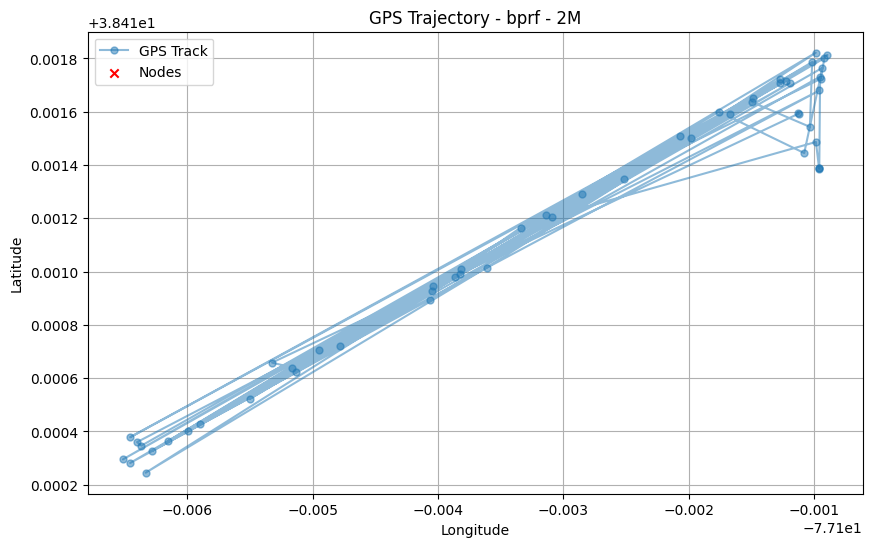

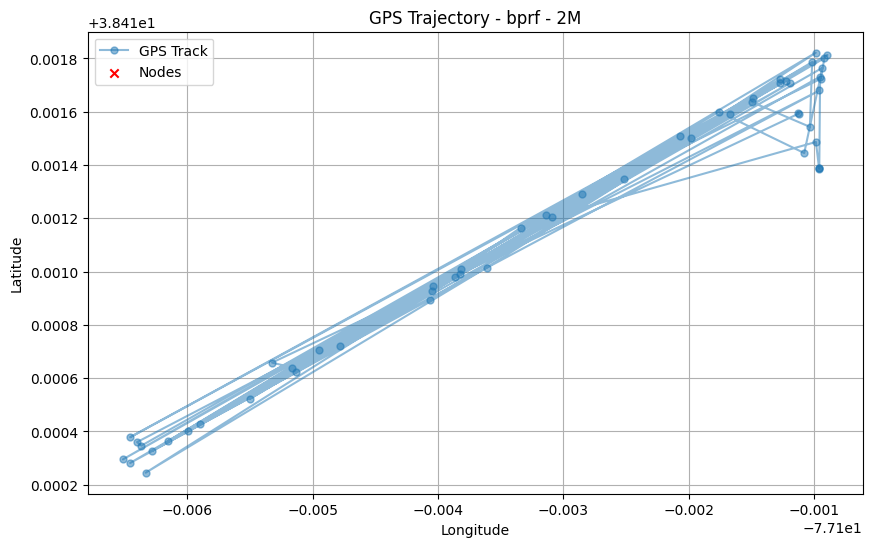

In [8]:
locations = run_info['location'].unique()
for loc in locations:
    runs = run_info[run_info['location'] == loc]
    placements = emplacement[emplacement['location'] == loc]
    for i, run in runs.iterrows():
        run_placements = placements[placements['date'] == run['date']]
        gps_log_file = run['gps-log-file']
        gps_data = read_gps_log(os.path.join('../data/position', gps_log_file))
        # Downsample
        gps_data.set_index('datetime', inplace=True)
        downsampled = gps_data.resample('min').first().dropna()
        plt.figure(figsize=(10, 6))
        # Plot trajectories
        plt.plot(downsampled['longitude'], downsampled['latitude'], marker='o', linestyle='-', markersize=5, label='GPS Track', alpha=0.5)
        # Plot microphone locations
        plt.scatter(run_placements['lon'], run_placements['lat'], marker='x', c='red', label='Nodes')
        plt.title(f'GPS Trajectory - {loc} - {run["target-id"]}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True)
        plt.legend()
        plt.show()

In [13]:
for logfile in os.listdir('../data/position/'):
    print(logfile)
    gps_data = pd.read_csv(os.path.join('../data/position/', logfile))
    try:
        gps_data['datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['time'], format='mixed')
        gps_data['date'] = pd.to_datetime(gps_data['date'], format='%Y-%m-%d')
        gps_data['time'] = pd.to_datetime(gps_data['time'], format='%H:%M:%S')
    except Exception as e:
        print(e)
        try:
            gps_data['datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['time'], format='mixed')
            gps_data['date'] = pd.to_datetime(gps_data['date'], format='%m/%d/%y')
            gps_data['time'] = pd.to_datetime(gps_data['time'], format='%H:%M:%S')
        except Exception as e:
            print(e)
            pass
    print(gps_data.head())
    

L16_2023-04-10.csv
unconverted data remains when parsing with format "%H:%M:%S": ".200000", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
unsupported operand type(s) for +: 'DatetimeArray' and 'str'
              time   latitude lat_dir   longitude long_dir  speed  course  \
0         20:28:00  31.616248       N -110.243523        W   0.00  160.16   
1  20:28:00.200000  31.616248       N -110.243523        W   0.00  160.16   
2  20:28:00.400000  31.616248       N -110.243523        W   0.00  160.16   
3  20:28:00.600000  31.616248       N -110.243523        W   0.00  160.16   
4  20:28:00.800000  31.616248       N -110.243523        W   0.01  160.16   

        date            